In [ ]:
!pip -q install torch torchaudio scikit-learn matplotlib tqdm


In [ ]:
import torch
import os, random, math, time
import torchaudio
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS

root = "./data_speechcommands"
os.makedirs(root, exist_ok=True)



train_base = SPEECHCOMMANDS(root, subset="training", download=True)
val_base   = SPEECHCOMMANDS(root, subset="validation", download=True)
test_base  = SPEECHCOMMANDS(root, subset="testing", download=True)
TARGET_LABELS = ["yes", "no", "up", "down"]
label_map = {l:i for i,l in enumerate(TARGET_LABELS)}
NUM_CLASSES = len(TARGET_LABELS)


In [ ]:
TARGET_SR = 16000
TARGET_LEN = 16000

mel_tf = torchaudio.transforms.MelSpectrogram(
    sample_rate=TARGET_SR,
    n_mels=64
)

db_tf = torchaudio.transforms.AmplitudeToDB()

def pad_or_trim(x):
    if x.shape[-1] < TARGET_LEN:
        return torch.nn.functional.pad(x, (0, TARGET_LEN - x.shape[-1]))
    return x[:TARGET_LEN]


In [ ]:
class FusionDataset(Dataset):
    def __init__(self, base):
        self.data = []
        for wav, sr, label, *_ in base:
            if label in TARGET_LABELS:
                wav = pad_or_trim(wav.squeeze())
                spec = db_tf(mel_tf(wav))
                self.data.append((wav, spec, label_map[label]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        raw, spec, label = self.data[idx]
        return raw, spec.unsqueeze(0), label


In [ ]:
BATCH = 128

train_ds = FusionDataset(train_base)
val_ds   = FusionDataset(val_base)
test_ds  = FusionDataset(test_base)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH)
test_loader  = DataLoader(test_ds, batch_size=BATCH)

print(len(train_ds), len(val_ds), len(test_ds))

12440 1530 1655


In [ ]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00


In [ ]:
class RawBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(32, 128)

    def forward(self, x):
        x = x.unsqueeze(1)      # (B,1,T)
        x = self.net(x)
        x = x.squeeze(-1)
        return self.fc(x)


In [ ]:
class SpecBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(32, 128)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [ ]:
class RawOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.raw = RawBranch()
        self.cls = nn.Linear(128, NUM_CLASSES)

    def forward(self, raw, spec=None):
        return self.cls(self.raw(raw))


In [ ]:
class SpecOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.spec = SpecBranch()
        self.cls = nn.Linear(128, NUM_CLASSES)

    def forward(self, raw, spec):
        return self.cls(self.spec(spec))


In [ ]:
class FusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.raw = RawBranch()
        self.spec = SpecBranch()
        self.cls = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, raw, spec):
        zr = self.raw(raw)
        zs = self.spec(spec)
        z  = torch.cat([zr, zs], dim=1)
        return self.cls(z)


In [ ]:
def train_model(model, epochs=10):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(epochs):
        model.train()
        for raw, spec, y in train_loader:
            raw, spec, y = raw.to(device), spec.to(device), y.to(device)

            opt.zero_grad()
            loss = loss_fn(model(raw, spec), y)
            loss.backward()
            opt.step()

        print(f"Epoch {ep+1}/{epochs} done")

    return model


In [ ]:
def evaluate(model):
    model.eval()
    ys, ps = [], []

    with torch.no_grad():
        for raw, spec, y in test_loader:
            out = model(raw.to(device), spec.to(device))
            ps.extend(out.argmax(1).cpu().numpy())
            ys.extend(y.numpy())

    acc = accuracy_score(ys, ps)
    f1  = f1_score(ys, ps, average="macro")
    cm  = confusion_matrix(ys, ps)

    print("Accuracy:", acc)
    print("F1-score:", f1)
    print("Confusion Matrix:\n", cm)


In [ ]:
print("Raw Only Model")
raw_model = train_model(RawOnlyModel())
evaluate(raw_model)

print("\nSpectrogram Only Model")
spec_model = train_model(SpecOnlyModel())
evaluate(spec_model)

print("\nFusion Model")
fusion_model = train_model(FusionModel())
evaluate(fusion_model)


Raw Only Model
Epoch 1/10 done
Epoch 2/10 done
Epoch 3/10 done
Epoch 4/10 done
Epoch 5/10 done
Epoch 6/10 done
Epoch 7/10 done
Epoch 8/10 done
Epoch 9/10 done
Epoch 10/10 done
Accuracy: 0.6574018126888218
F1-score: 0.6460207591543528
Confusion Matrix:
 [[358  17  26  18]
 [ 33 222  57  93]
 [ 38  25 335  27]
 [ 43 132  58 173]]

Spectrogram Only Model
Epoch 1/10 done
Epoch 2/10 done
Epoch 3/10 done
Epoch 4/10 done
Epoch 5/10 done
Epoch 6/10 done
Epoch 7/10 done
Epoch 8/10 done
Epoch 9/10 done
Epoch 10/10 done
Accuracy: 0.7945619335347432
F1-score: 0.7929885889274213
Confusion Matrix:
 [[337  34  41   7]
 [ 19 264  16 106]
 [  7  23 368  27]
 [  6  36  18 346]]

Fusion Model
Epoch 1/10 done
Epoch 2/10 done
Epoch 3/10 done
Epoch 4/10 done
Epoch 5/10 done
Epoch 6/10 done
Epoch 7/10 done
Epoch 8/10 done
Epoch 9/10 done
Epoch 10/10 done
Accuracy: 0.8441087613293051
F1-score: 0.8413123472612448
Confusion Matrix:
 [[393  10  14   2]
 [ 31 302  14  58]
 [  6  15 393  11]
 [  6  70  21 309]]


In [ ]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,5))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()

    ticks = range(NUM_CLASSES)
    plt.xticks(ticks, TARGET_LABELS, rotation=45)
    plt.yticks(ticks, TARGET_LABELS)

    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center", color="black")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_with_plot(model, name):
    model.eval()
    ys, ps = [], []

    with torch.no_grad():
        for raw, spec, y in test_loader:
            out = model(raw.to(device), spec.to(device))
            ps.extend(out.argmax(1).cpu().numpy())
            ys.extend(y.numpy())

    acc = accuracy_score(ys, ps)
    f1  = f1_score(ys, ps, average="macro")
    cm  = confusion_matrix(ys, ps)

    print(f"{name} Model")
    print("Accuracy:", acc)
    print("F1-score:", f1)

    plot_confusion_matrix(cm, f"{name} – Confusion Matrix")


Raw Only Model
Accuracy: 0.6574018126888218
F1-score: 0.6460207591543528


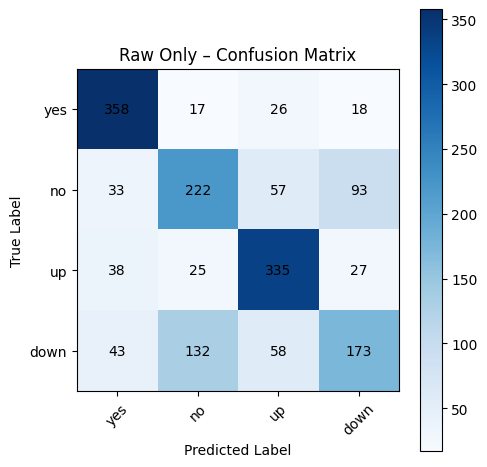

Spectrogram Only Model
Accuracy: 0.7945619335347432
F1-score: 0.7929885889274213


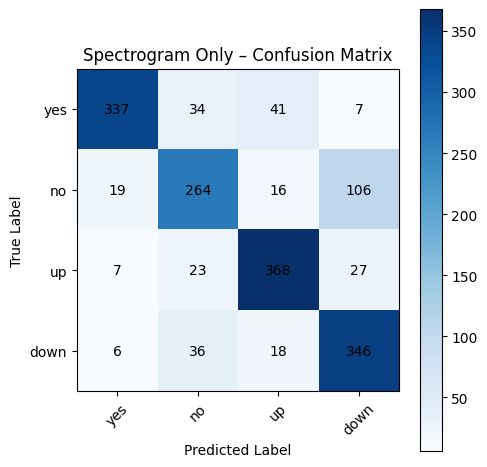

Fusion Model
Accuracy: 0.8441087613293051
F1-score: 0.8413123472612448


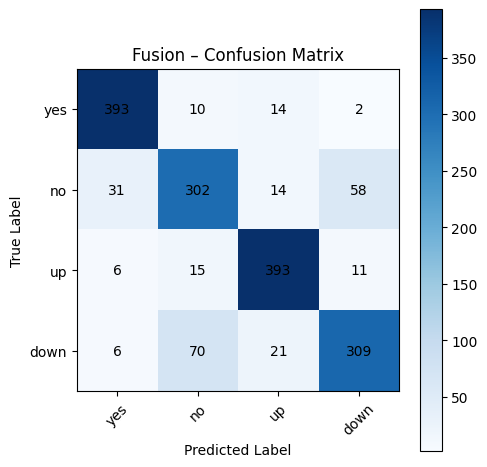

In [ ]:
evaluate_with_plot(raw_model, "Raw Only")
evaluate_with_plot(spec_model, "Spectrogram Only")
evaluate_with_plot(fusion_model, "Fusion")


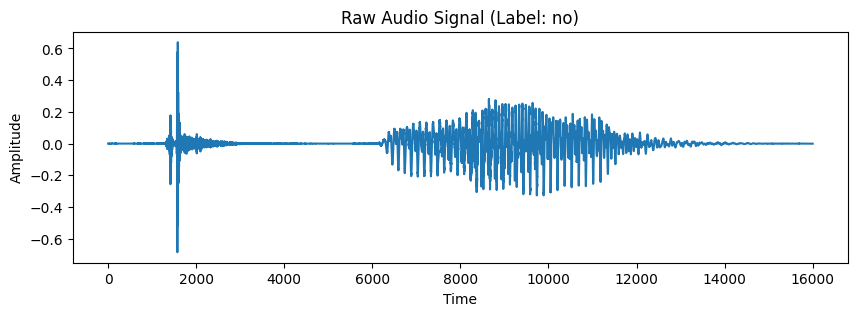

In [ ]:
raw, spec, label = test_ds[0]

plt.figure(figsize=(10,3))
plt.plot(raw.numpy())
plt.title(f"Raw Audio Signal (Label: {TARGET_LABELS[label]})")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


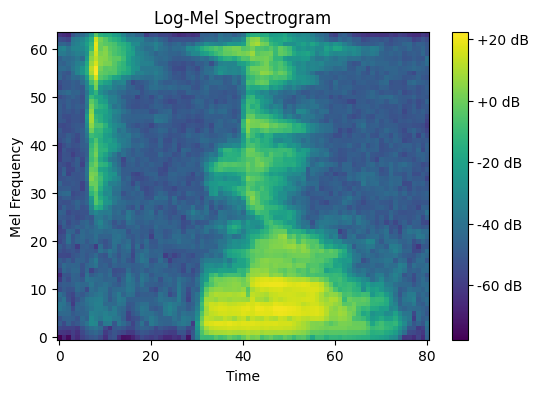

In [ ]:
plt.figure(figsize=(6,4))
plt.imshow(spec.squeeze().numpy(), aspect="auto", origin="lower")
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()
